# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Применение в бизнесе

Если вы еще не прочитали [статью](https://habr.com/ru/company/hh/blog/347276/) о рекомендательных системах и поиске в hh.ru, то обязательно прочитайте

- 2-ух уровневая система применяется во многих компаниях
- Зачастую уровней > 2
- Идем от более простых эвристик/моделей к более сложным
- Фичи из моделей первого уровня (embeddings, biases из ALS) можно использовать в последующих моделях

Также решения на основе 2-ух уровневых рекомендаций заняли все топ-10 мест в соревновании X5 Retail hero. 

- [Презентация](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) и [Код](https://github.com/aprotopopov/retailhero_recommender) решения 2-ого места
- [Код](https://vk.com/away.php?utf=1&to=https%3A%2F%2Fgithub.com%2Fmike-chesnokov%2Fx5_retailhero_2020_recs) решения 9-ого места

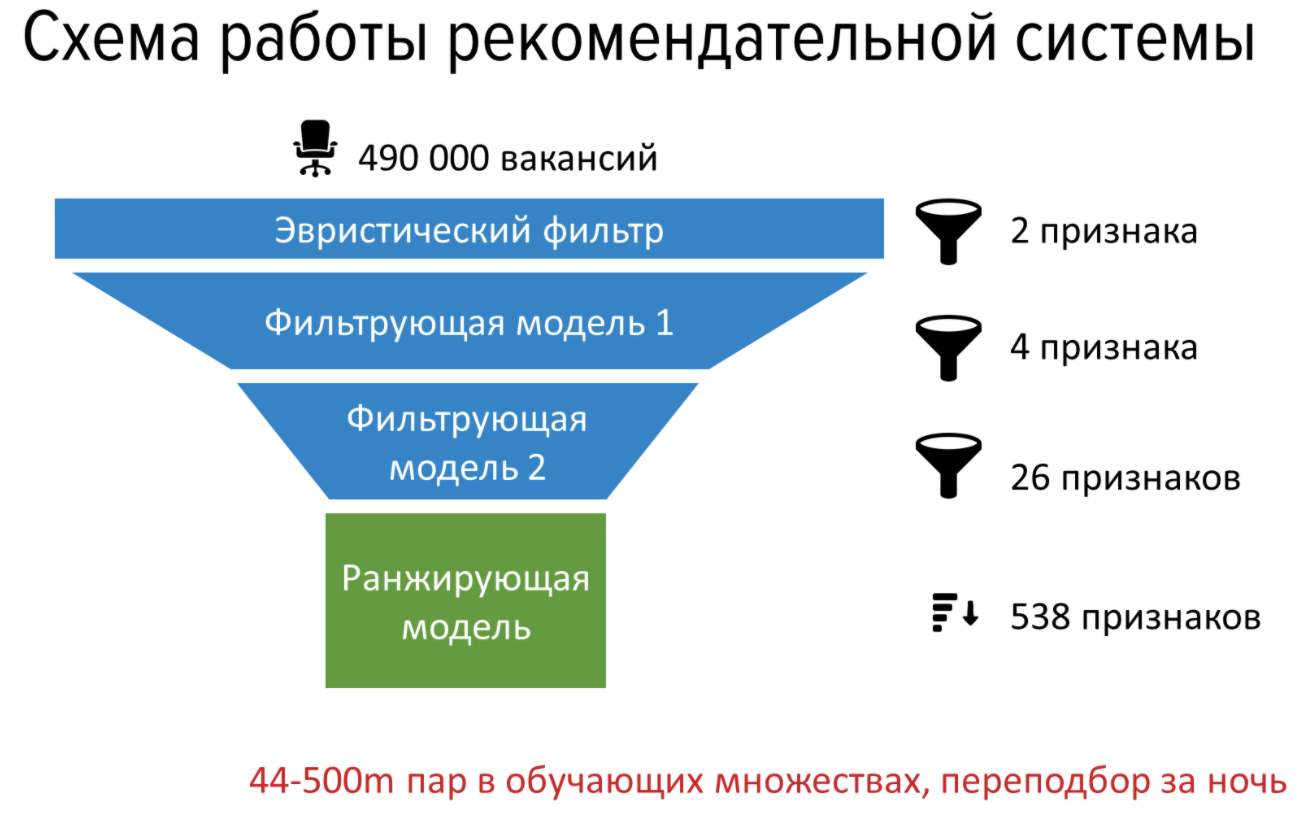

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

Код для src, utils, metrics вы можете скачать с [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

user_id    basket_id  day    item_id  quantity  sales_value  store_id  \
0     2375  26984851472  1.0  1004906.0       1.0         1.39     364.0   
1     2375  26984851472  1.0  1033142.0       1.0         0.82     364.0   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0         -0.6      1631.0      1.0          0.0                0.0  
1          0.0      1631.0      1.0          0.0                0.0

In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 43434 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [5]:
recommender.get_als_recommendations(2375, N=5)

ValueError: user_items must contain 1 row for every user in userids

In [ ]:
recommender.get_own_recommendations(2375, N=5)

In [ ]:
recommender.get_similar_items_recommendation(2375, N=5)

In [ ]:
recommender.get_similar_users_recommendation(2375, N=5)

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [ ]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

In [ ]:
# your_code

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [ ]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

In [ ]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [ ]:
users_lvl_2.head(2)

In [ ]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

In [ ]:
users_lvl_2.shape[0]

In [ ]:
users_lvl_2['user_id'].nunique()

In [ ]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [ ]:
targets_lvl_2.head(2)

(!) На каждого юзера 50 item_id-кандидатов

In [ ]:
targets_lvl_2['target'].mean()

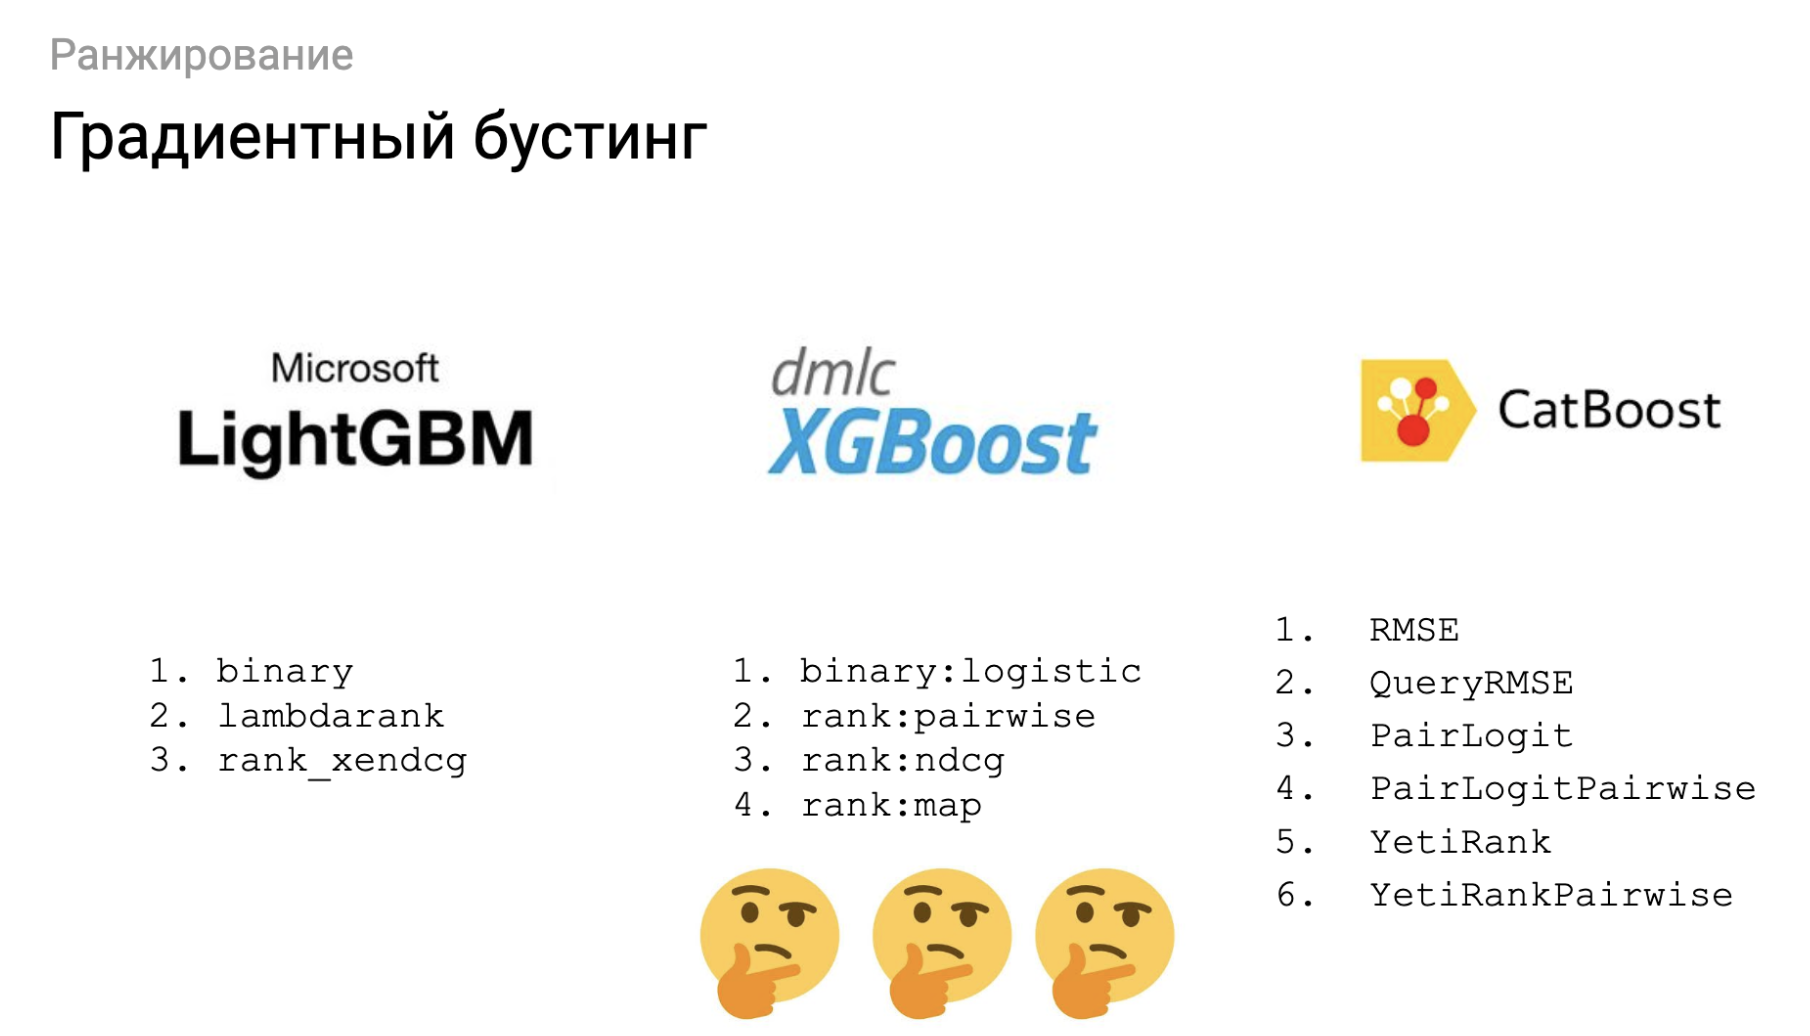

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

In [ ]:
item_features.head(2)

In [ ]:
user_features.head(2)

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [ ]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [ ]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

In [ ]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера